In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [2]:
def view_imgs(imgs, cols=4):
    """ this function to show a list of imgs using subplot """
    rows = np.ceil(len(imgs)/cols)
    width = imgs[0].shape[1]
    height = imgs[0].shape[0]
    figsize = width/70, height/60
    plt.figure(figsize= figsize)
    for i, img in enumerate(imgs):
        camp = 'gray' if len(img.shape) < 3 else None
        plt.subplot(rows, cols, i+1)
        plt.imshow(img,cmap=camp)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [3]:
dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [4]:
test_imgs = glob.glob('test_images/*.jpg')

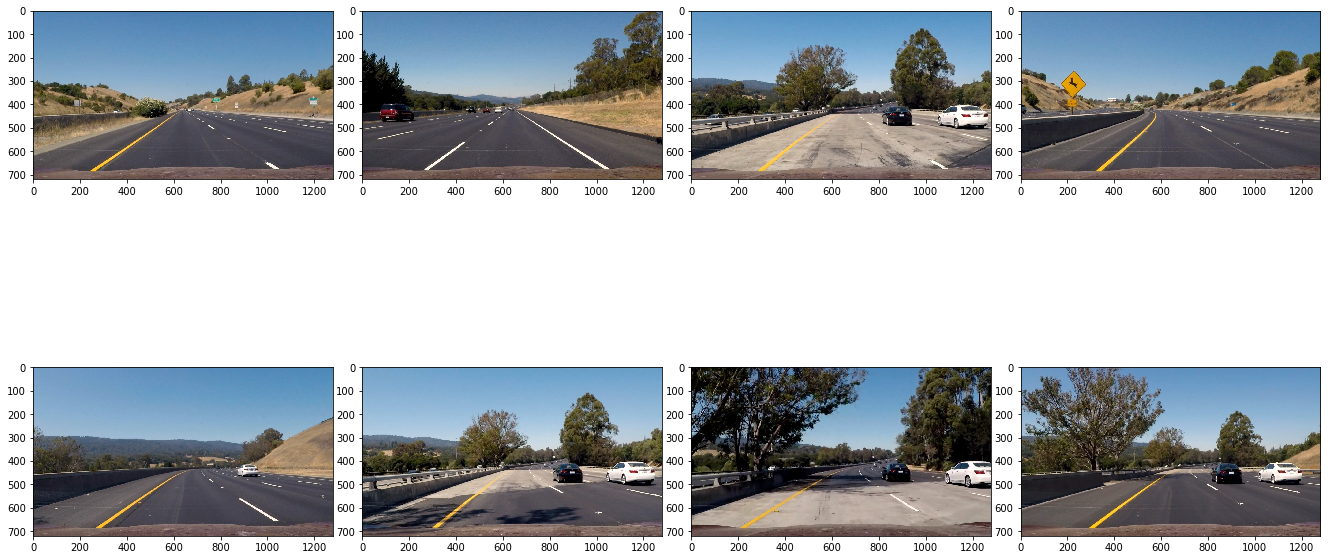

In [5]:
test_undist = []
for indx, img_name in enumerate(test_imgs):
    img = cv2.imread(img_name)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'output_images/test_undist/' + str(indx) + '.jpg'
    cv2.imwrite(write_name,dst)
    test_undist.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
view_imgs(test_undist)

In [6]:
def hls_select(img, thresh=(150, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    binary = np.zeros_like(s)
    binary[(s>thresh[0])&(s<=thresh[1])] = 1
    binary[gray < 20] = 0
    #s[(s>thresh[1])|(s<=thresh[0])] = 0
    return binary

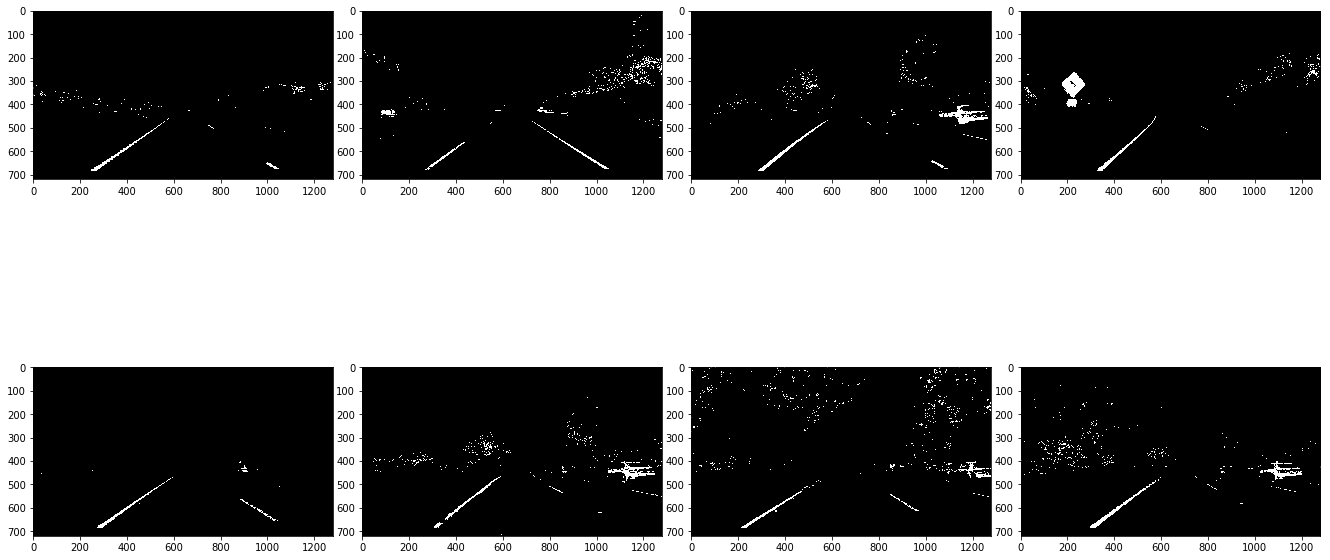

In [7]:
test_color_thresh = []
for indx, img in enumerate(test_undist):
    thresh = hls_select(img)
    write_name = 'output_images/test_color_thresh/' + str(indx) + '.jpg'
    cv2.imwrite(write_name,255*thresh)
    test_color_thresh.append(thresh)
view_imgs(test_color_thresh)

In [8]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3 ,thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) if len(img.shape) > 2 else img 
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) if orient == 'x' else \
            cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) if len(img.shape) > 2 else img 
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel>= mag_thresh[0]) & (scaled_sobel<= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask # Remove this line
    return binary_output

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) if len(img.shape) > 2 else img 
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(absy, absx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >=thresh[0]) & (direction <= thresh[1]) ] =1
    # 6) Return this mask as your binary_output image
    binary_output = mask # Remove this line
    return binary_output

In [11]:
def thresholding(image, ksize = 7, gradx_thresh = (60,255), grady_thresh = (60,255), mag_threshold=(30, 255), dir_thresh = (0.5, 1.1)):
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh = mag_threshold)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1))] = 1
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

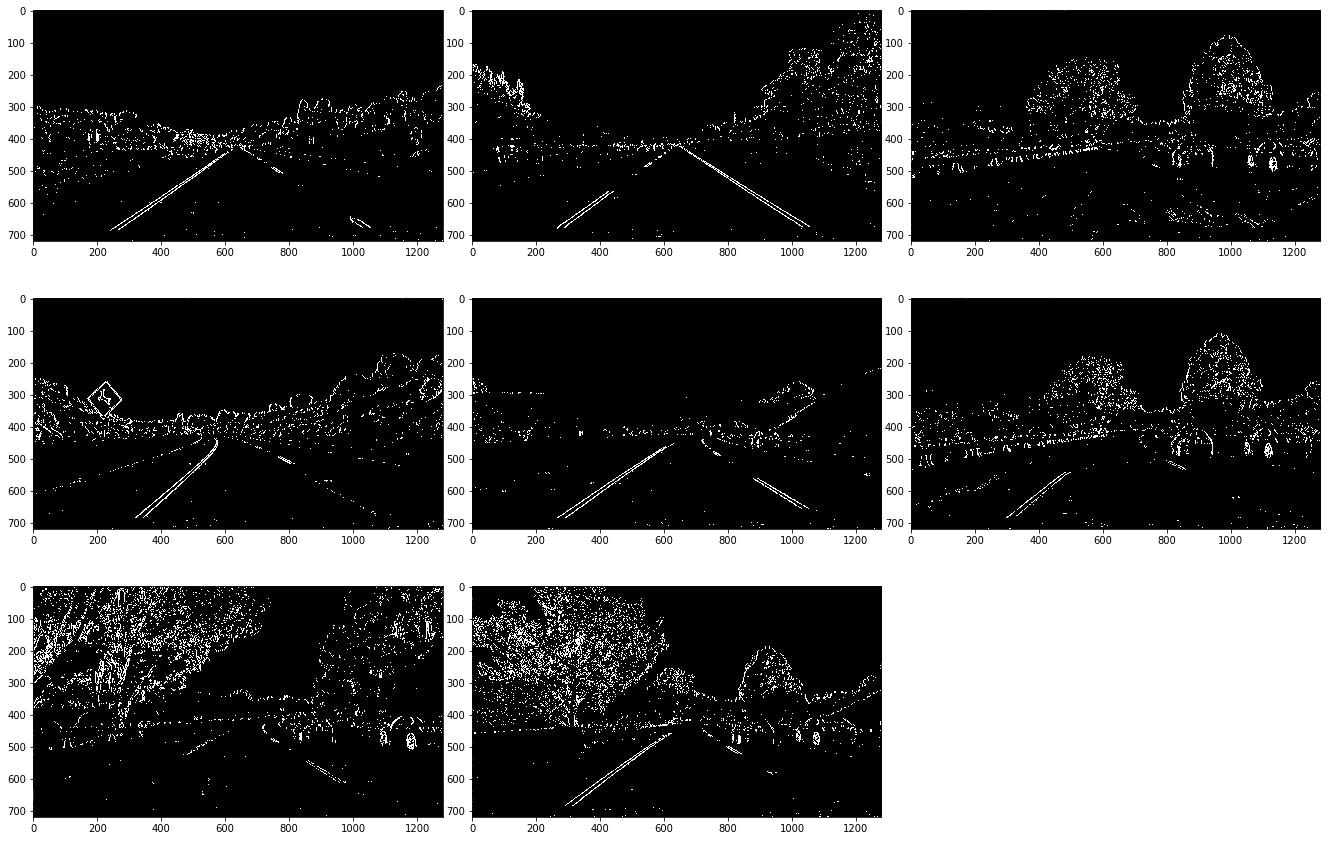

In [12]:
test_undist_thresh = []
for indx, img in enumerate(test_undist):    
    thresh = thresholding(img)
    write_name = 'output_images/test_undist_thresh/' + str(indx) + '.jpg'
    plt.imsave(write_name,255*thresh,cmap ='gray')
    test_undist_thresh.append(thresh)
view_imgs(test_undist_thresh,cols=3)
#plt.figure(figsize=(20,20))
#plt.imshow(test_undist_thresh[6],cmap='gray')

In [13]:
def combine_thresh(thresh_c, thresh_s):
    thresh_s[thresh_c > 0] = 1
    return thresh_s

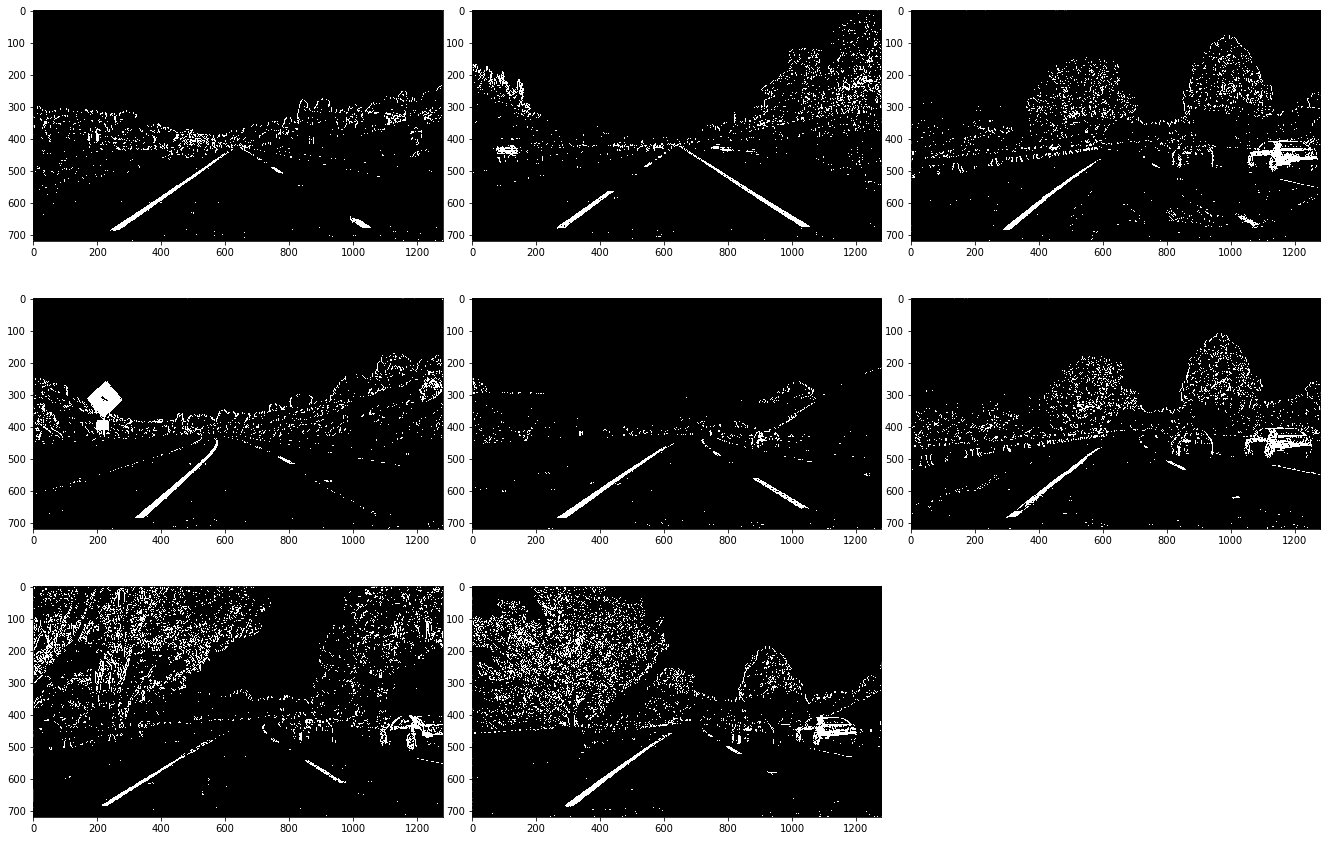

In [14]:
test_all_thresh = []
for indx, img in enumerate(test_undist_thresh):
    img[test_color_thresh[indx]>0] = 1
    write_name = 'output_images/test_all_thresh/' + str(indx) + '.jpg'
    #plt.imsave(write_name, 255*img, cmap ='gray')
    test_all_thresh.append(img)
#plt.figure(figsize=(20,20))
#plt.imshow(test_all_thresh[3],cmap='gray')
view_imgs(test_all_thresh,cols=3)

In [15]:
def threshold(img, ksize=7, gradx_thresh=(60,255), mag_thresh=(60, 255), dir_thresh=(0.7, 1.1), color_thresh=(150,255), gray_thresh = 20):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #l = hls[:,:,1]
    s = hls[:,:,2]
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=ksize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobelmag = np.uint8(255*mag/np.max(mag))

    direction = np.arctan2(abs_sobely, abs_sobelx)

    mask_c = np.zeros_like(s)
    mask_c[(s>color_thresh[0])&(s<=color_thresh[1]) & (gray > gray_thresh)] = 1
    
    mask_x = np.zeros_like(s)
    mask_x[((scaled_sobelx >= gradx_thresh[0]) & (scaled_sobelx <= gradx_thresh[1])) | \
            ((scaled_sobelmag >=mag_thresh[0]) & (scaled_sobelmag <= mag_thresh[1]) & (direction >=dir_thresh[0]) & (direction <= dir_thresh[1]))] = 1

    return mask_x | mask_c

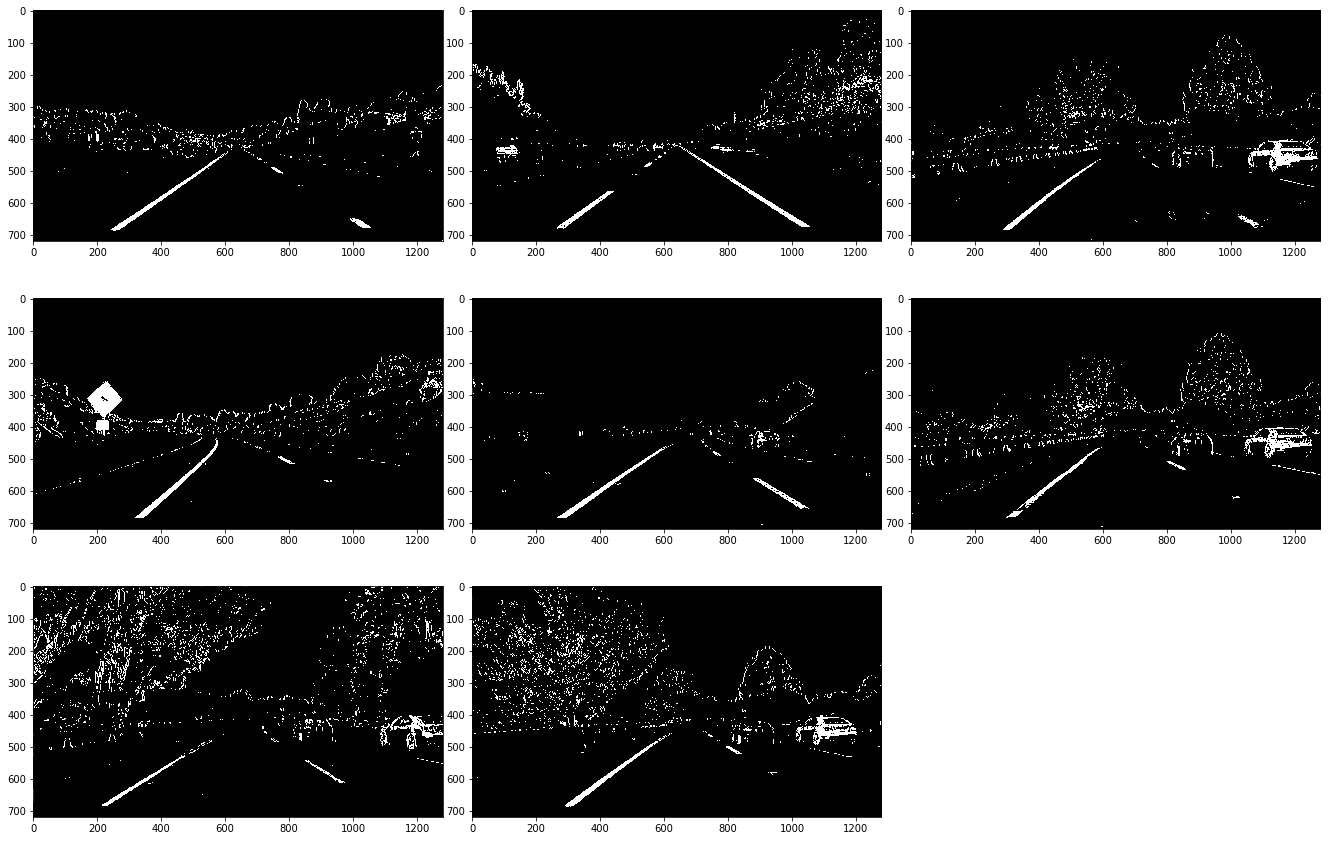

In [16]:
test_all_thresh = []
for indx, img in enumerate(test_undist):
    img = threshold(img)
    write_name = 'output_images/test_all_thresh/' + str(indx) + '.jpg'
    plt.imsave(write_name, 255*img, cmap ='gray')
    test_all_thresh.append(img)
#plt.figure(figsize=(20,20))
#plt.imshow(test_all_thresh[3],cmap='gray')
view_imgs(test_all_thresh,cols=3)

In [32]:
warp_pickle = pickle.load( open( "warp_pickle.p", "rb" ) )
M = warp_pickle["M"]
INV_M = warp_pickle["INV_M"]

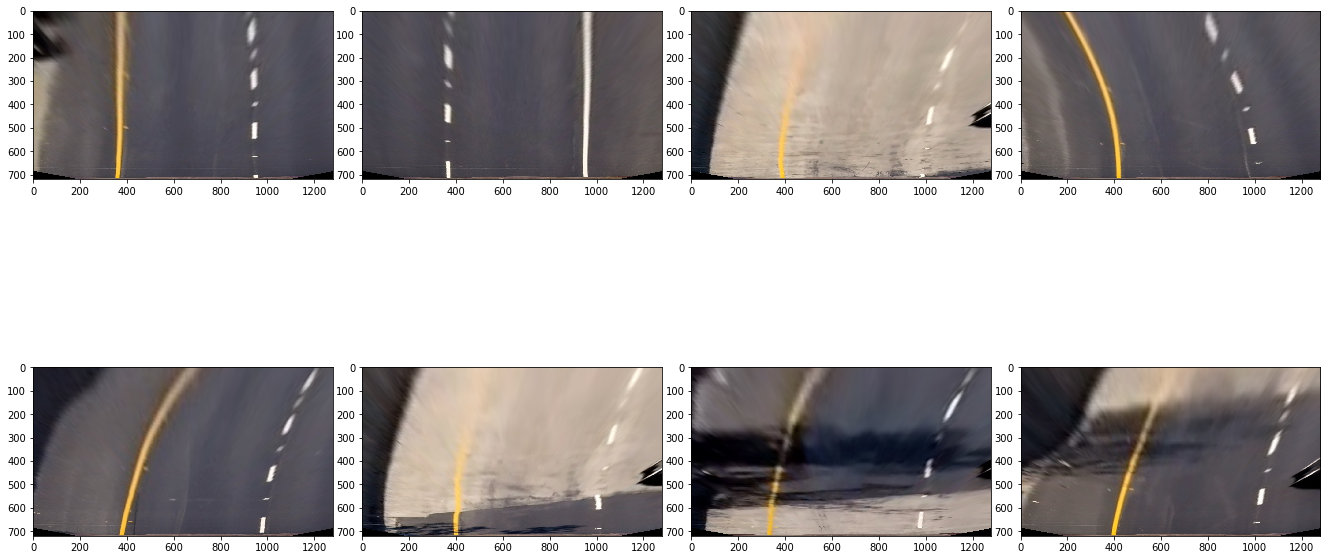

In [33]:
test_unwarped = []
for indx, img in enumerate(test_undist):    
    unwarp = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    write_name = 'output_images/test_unwarped/' + str(indx) + '.jpg'
    plt.imsave(write_name,unwarp)
    test_unwarped.append(unwarp)
view_imgs(test_unwarped)

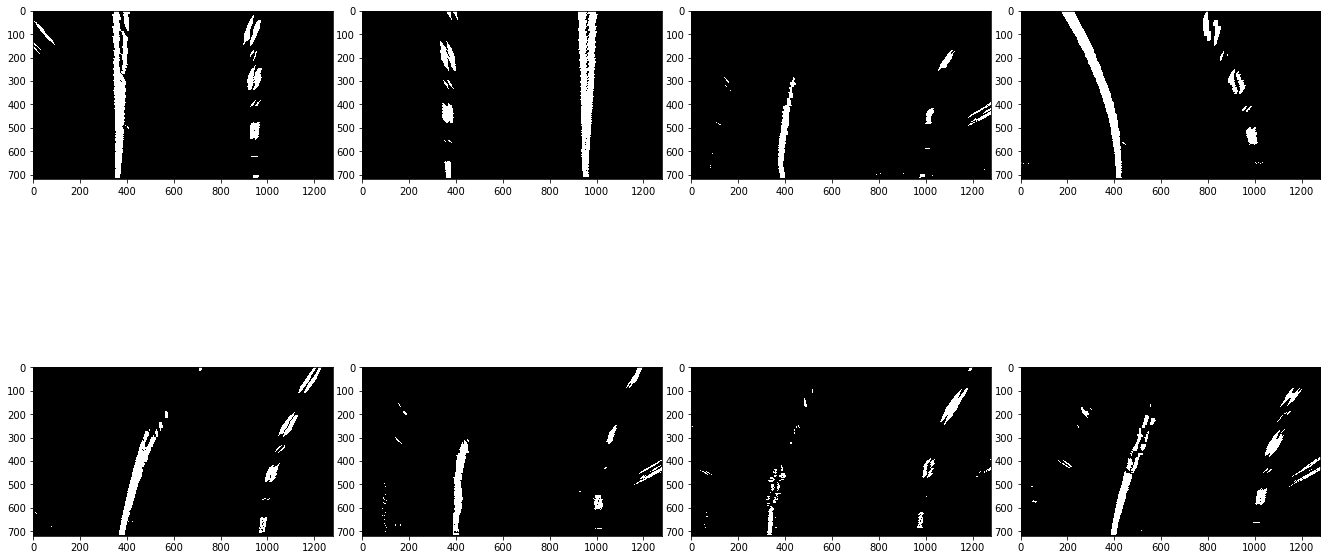

In [34]:
test_all_unwarped = []
for indx, img in enumerate(test_all_thresh):    
    unwarp = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    write_name = 'output_images/test_all_unwarped/' + str(indx) + '.jpg'
    plt.imsave(write_name,unwarp,cmap ='gray')
    test_all_unwarped.append(unwarp)
view_imgs(test_all_unwarped)

In [35]:
def find_lane_pixels(binary_warped, nwindows = 9, margin = 100, minpix = 50):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.zeros((binary_warped.shape[0], binary_warped.shape[1], 3),dtype=np.uint8)
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])  #index
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #index

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy>win_y_low)&(nonzeroy<win_y_high)\
                            &(nonzerox>win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>win_y_low)&(nonzeroy<win_y_high)\
                            &(nonzerox>win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))  
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

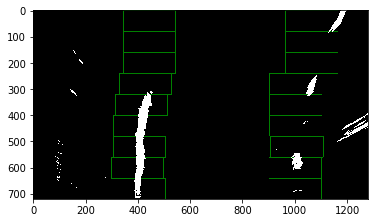

In [36]:
img = test_all_unwarped[5] 
out_img = find_lane_pixels(img,nwindows = 9, margin = 100, minpix = 120)[4]
out_img = cv2.addWeighted(out_img,0.5,255*np.dstack((img,img,img)),1,0)
plt.imshow(out_img)

In [79]:
def get_lane_points_and_curvature(leftx, lefty, rightx, righty, ploty, width):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    y_eval *= ym_per_pix
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])
    distance = (left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]+\
                right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2])/2 - width*xm_per_pix/2
    return left_fitx, right_fitx, left_curverad, right_curverad, distance

15207.927782946525 8017.906534705107 0.08471818546414456
24.490828957395138
2125.4570002928476 4928.323915070181 0.10795412142939442
16.9690376953846
438.5022958441757 383.69806051996943 0.2517132240706679
37.00899677837697
375.9650230651257 519.5972867776618 0.416003147945625
31.696545311274576
365.7288782645447 437.93248296686613 0.20841215313724737
66.14390177752432
586.5675038186711 443.6708865856665 0.3336219895258914
52.08714283600784
368.7722409496608 328.32907564744426 0.08819316350205897
11.083502678097034
892.2901896069541 617.8858025735033 0.2863529762935504
41.05272374348522


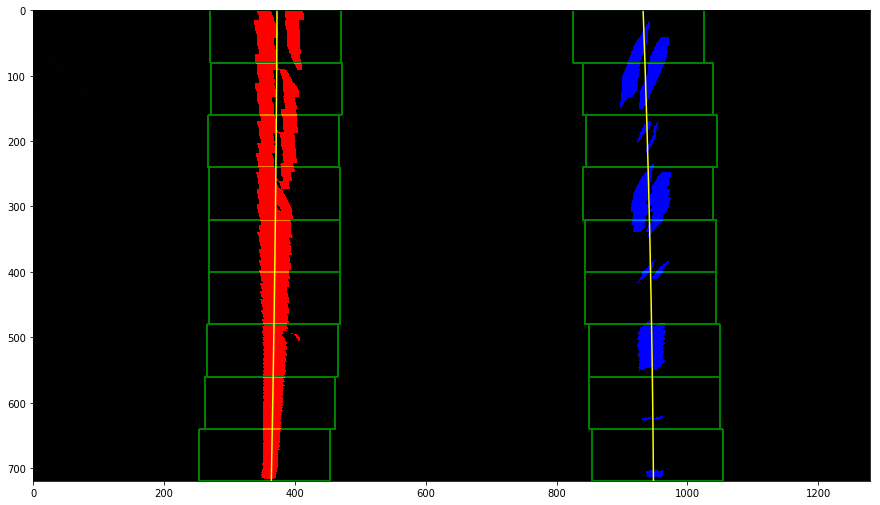

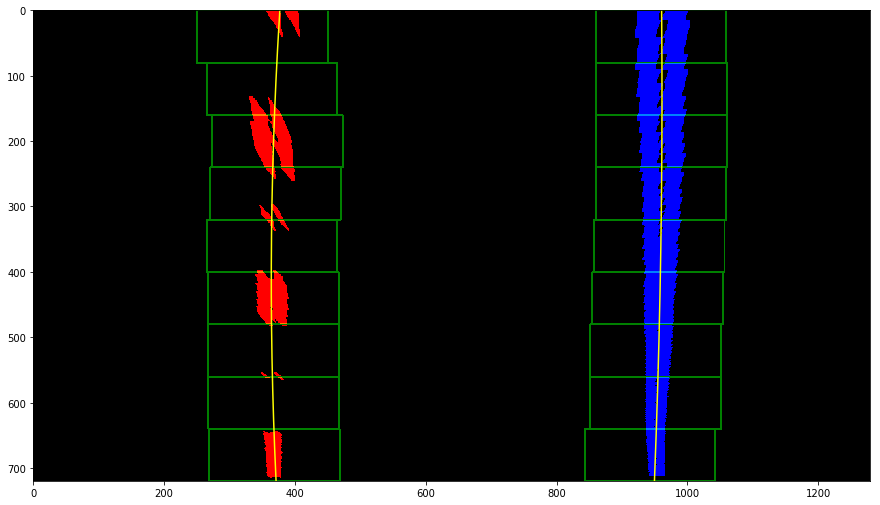

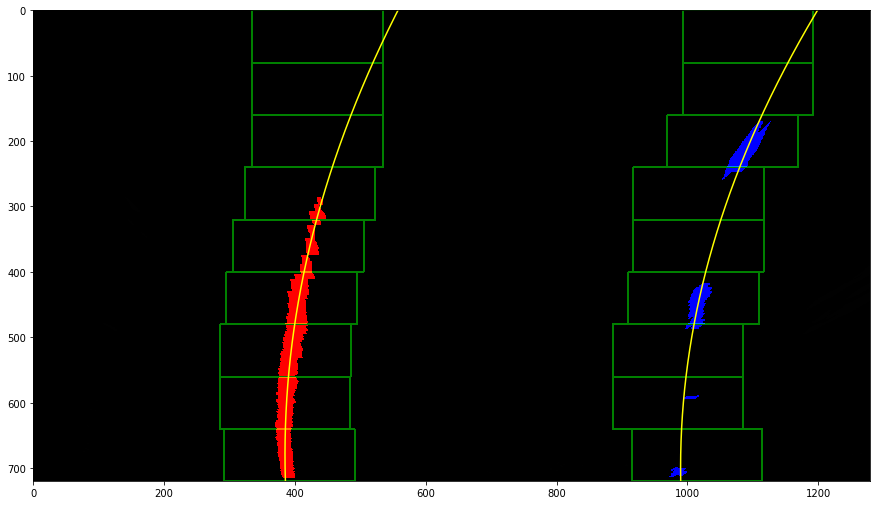

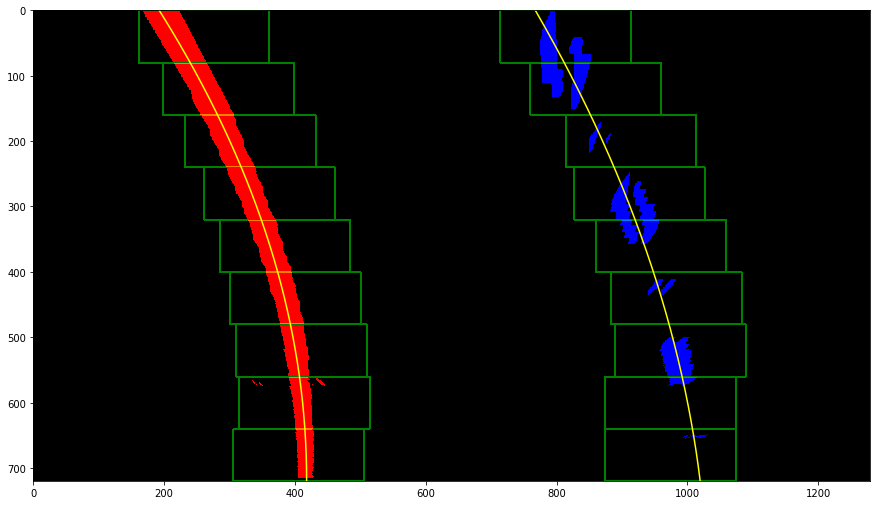

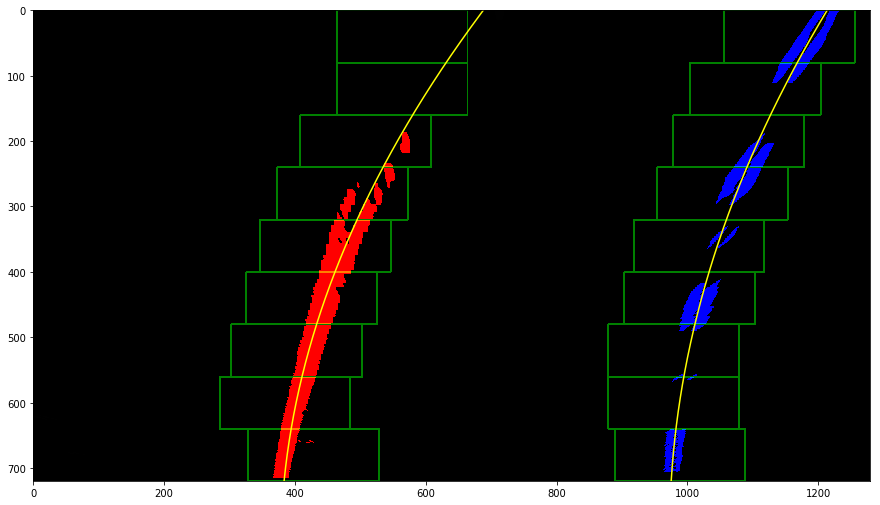

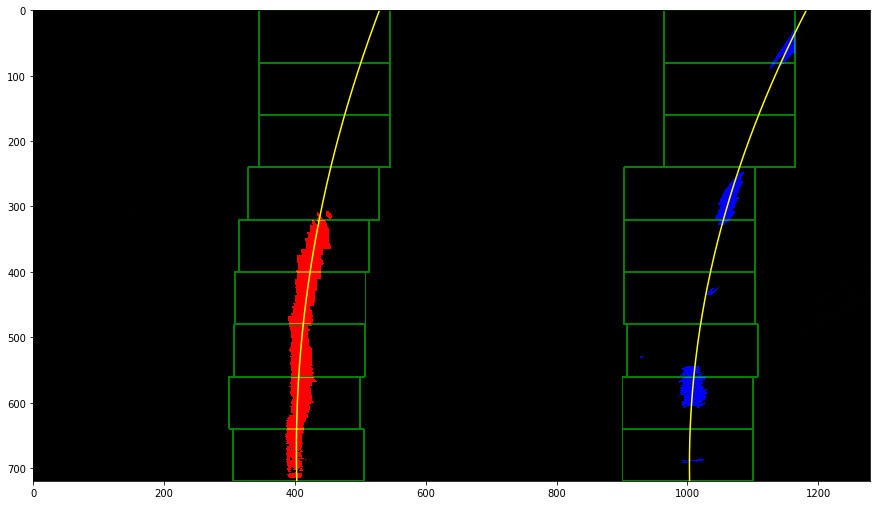

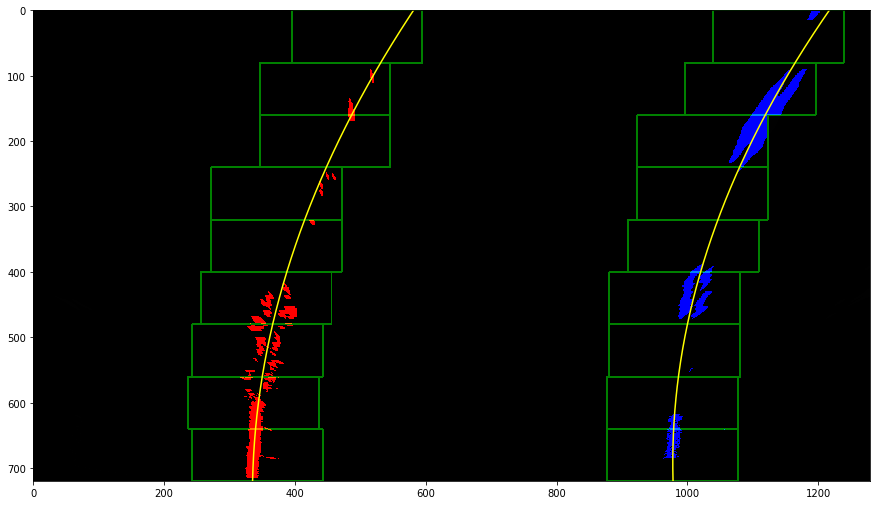

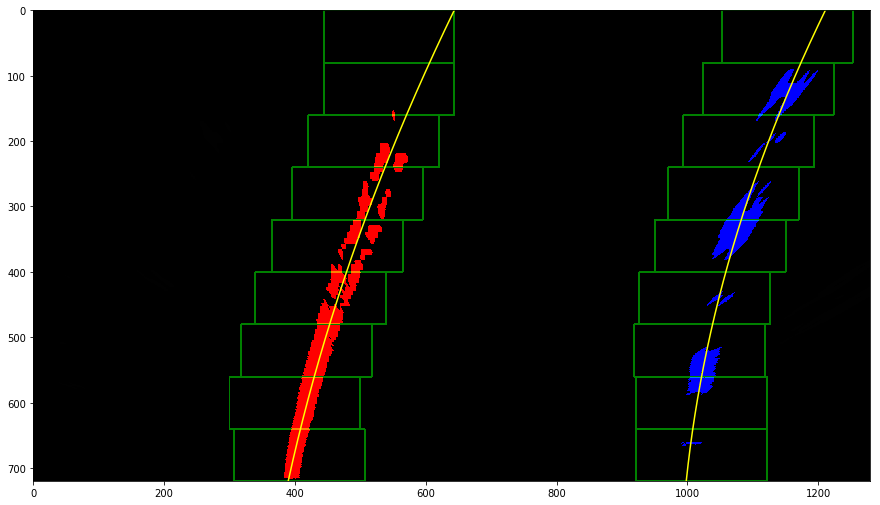

In [80]:
prespective_lines_detected = []

ym_per_pix, xm_per_pix = 30/720 ,3.7/700
nwindows=9
margin=100
minpix=120

for indx, img in enumerate(test_all_unwarped):    
    img = np.array(img,np.uint8)
    leftx, lefty, rightx, righty, rect = find_lane_pixels(test_all_unwarped[indx],nwindows, margin, minpix)
    
    ploty = np.linspace(img.shape[0]-1, 0, img.shape[0]) 
    left_fitx, right_fitx, left_curverad, right_curverad, distance = get_lane_points_and_curvature(leftx, lefty, rightx, righty, ploty, img.shape[1])
    
    lane_width = right_fitx - left_fitx
    np.max(lane_width) - np.min(lane_width)
    
    out_img = np.dstack((img,img,img))
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img = cv2.addWeighted(out_img,1,rect,0.5,0)
    write_name = 'output_images/prespective_lines_detected/' + str(indx) + '.jpg'
    
    fig = plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    plt.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    #fig.savefig(write_name)
    prespective_lines_detected.append(out_img)
    print(left_curverad, right_curverad, distance)
    print(np.max(lane_width) - np.min(lane_width))

In [ ]:
lane_detected = []
ym_per_pix, xm_per_pix = 30/720 ,3.7/700
nwindows=9
margin=100
minpix=120
for indx, img in enumerate(test_all_unwarped):    
    img = np.array(img,np.uint8)
    leftx, lefty, rightx, righty, rect = find_lane_pixels(test_all_unwarped[indx],nwindows, margin, minpix)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.arange(0,img.shape[0])[::-1]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane = np.array(np.zeros_like(img), dtype=np.int32)
    lane += np.arange(img.shape[1]).reshape(1,-1)
    lane[(lane < left_fitx.reshape(-1,1))[::-1] | (lane > right_fitx.reshape(-1,1))[::-1]] = 0
    lane[lane > 0]  = 255
    lane = np.array(lane,np.uint8)
    
    lane = np.dstack((np.zeros_like(lane),lane,np.zeros_like(lane)))
    
    lane = cv2.warpPerspective(lane, INV_M, lane.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    output = cv2.addWeighted(test_undist[indx], 1, lane, 0.5, 0.0)
    
    write_name = 'output_images/lane_detected/' + str(indx) + '.jpg'
    #fig = plt.figure(figsize=(15,15))
    #ax = plt.subplot(111)
    #plt.imshow(out_img)
    #plt.imshow(output)
    #ax.plot(left_fitx, ploty, color='yellow')
    #ax.plot(right_fitx, ploty, color='yellow')
    #fig.savefig(write_name)
    plt.imsave(write_name,output)
    
    lane_detected.append(output)
view_imgs(lane_detected)

In [57]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        
        self.old_fit = np.array([False])
        self.fit = np.array([False])
        
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.n_true = 0
        self.n_flase = 0
    
    def input(self, detected, xfit, radius_of_curvature):
        self.fit = 0.15 * self.old_fit + 0.85 * xfit if self.old_fit else xfit
        #if not detected:
        #    self.detected = False 
        #    self.old_fit = 0
        #    self.n_true = 0
        #    self.n_flase += 1
        #else:
        #    self.detected = True
        #    self.n_flase = 0
        #    self.n_true += 1
        #    self.old_fit = self.fit
    def output(self):
        return self.fit
            

In [58]:
left, right = Line(), Line()

In [59]:
def process_image(img, dist, mtx, nwindows=9, margin=50, minpix=120, thresh=50, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    
    ## undistortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #cobined thresholds
    comb = threshold(undist)
    
    #unwarping
    unwarp = cv2.warpPerspective(comb, M, comb.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    #get points
    leftx, lefty, rightx, righty,_ = find_lane_pixels(unwarp, nwindows, margin, minpix)
    
    ploty = np.linspace(img.shape[0]-1, 0, img.shape[0]) 
    left_fitx, right_fitx, left_curverad, right_curverad = get_lane_points_and_curvature(leftx, lefty, rightx, righty, ploty)
    
    lane_width = right_fitx - left_fitx
    #and (np.abs(left_curverad-right_curverad) < 1000 or min(left_curverad,right_curverad) > 2500)
    
    
    if np.max(lane_width) - np.min(lane_width) < 150 :
        left.input(True, left_fitx, left_curverad)
        left_fitx = left.output()
        
        right.input(True, right_fitx, right_curverad)
        right_fitx = right.output()
        
    else:
        #left.input(False, left_fitx, left_curverad)
        left_fitx = left.output()
        
        #right.input(False, right_fitx, right_curverad)
        right_fitx = right.output()
    
    #prepare lane green mask
    lane = np.array(np.zeros_like(unwarp), dtype=np.int32)
    lane += np.arange(unwarp.shape[1]).reshape(1,-1)
    lane[(lane < left_fitx.reshape(-1,1))[::-1] | (lane > right_fitx.reshape(-1,1))[::-1]] = 0
    lane[lane > 0]  = 255
    lane = np.array(lane,np.uint8)
    lane = np.dstack((np.zeros_like(lane),lane,np.zeros_like(lane)))

    #warp the lane mask to the original view
    lane = cv2.warpPerspective(lane, INV_M, lane.shape[1::-1], flags=cv2.INTER_LINEAR)
    output = cv2.addWeighted(undist, 1, lane, 0.5, 0.0)
        
    return output

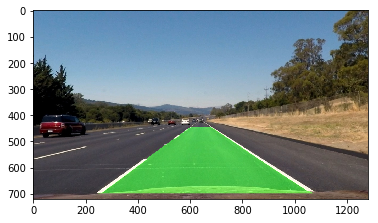

In [60]:
plt.imshow(process_image(test_undist[1], dist, mtx))

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip('project_video.mp4').subclip(20,30)
##clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(lambda img: process_image(img,dist,mtx)) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 250/251 [01:54<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 1min 56s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))